# ANALYSIS ON BANK_DATA_PREDICTION DATA SET
## _PREPARED BY OSKAR FURMANCZUK_

* low-level overview -> comments
* high-level overview -> markdown

### _Approach description_

To improve marketing campaign efficiency I want to build a model that takes information about clients and current macroeconomic indicators as inputs and returns 'y' column (which indicates a sold product). To build that model I will use the control group subset. The model on this set will indicate which person is highly interested in the matter of the campaign. Then I will compare model output with real labels of the campaign subset to calculate lift of implementing such a solution. I won't build model on campaign group subset because character of marketing contact (e.g. marker's voice, time of the day when contact was made) might highly impact people's decisions, thus deflect correlation with data.

### Importing basic packages an reading the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('bank_data_prediction_task.csv', index_col=0, low_memory=False)
df.shape

(41188, 22)

### DATA CLEANING
To check which rows contain the least data I counted "unknown" for every row

In [3]:
# counting "unknown" for every row
l = []
for i, r in df.iterrows():
    z = 0
    for j in r.values:
        if "unknown" in str(j):
            z += 1
    l.append((i,z))

l_2 = [k[1] for k in l]

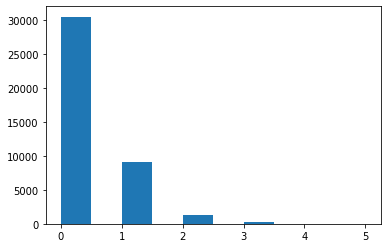

In [4]:
# histogram for number of "unknows" 
l_2 = [k[1] for k in l]

plt.hist(l_2)
plt.show()

In [5]:
# freq of number of "unknows"
freq_l = [(k,l_2.count(k)/len(l_2)) for k in range(6)]
freq_l

[(0, 0.7402155967757599),
 (1, 0.219335728853064),
 (2, 0.0324851898611246),
 (3, 0.0074293483538894825),
 (4, 0.0004855783237836263),
 (5, 4.855783237836263e-05)]

To decide what number of "unknown"s per row has to be left I checked the differences between next values

In [6]:
# calc to decide what number of "unknows" is too much
for i in range(len(freq_l)):
    try:
        print(freq_l[i][1]/freq_l[i+1][1])
    except:
        print("last row cannot be divided")

3.3748062873588665
6.751868460388639
4.372549019607843
15.3
10.0
last row cannot be divided


* 15,3 is the highest so I dropped rows with more than 3 "unknown"s (dropped less than 1% of the whole data set)

In [7]:
# returning numbers of rows where count of "unknown" is equal or more than 4
l_index = []
for p in l:
    if p[1] >= 4 :
        l_index.append(p[0] - 1)

In [8]:
# dropping unwanted rows
df_cleaned = df.drop(l_index)

I also dropped rows where "cons.price.idx" is NA. There is only 113 rows like that (0.27% of the whole data set).

In [9]:
# dropping rows where "cons.price.idx" is NA 
N = df_cleaned["cons.price.idx"]
df_cleaned = df_cleaned[pd.notna(N)]

### PREPROCESSING

In [10]:
# imports from sklearn
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, recall_score, precision_score

In [11]:
# dividing dfs into two sets
df_contr = df_cleaned[(df_cleaned.test_control_flag =='control group')]
df_camp = df_cleaned[(df_cleaned.test_control_flag =='campaign group')]

To select proper columns for input I dropped all "NA" colums, label column and "test_control_flag" column

In [12]:
# dividing columns into inputs and labels
X_contr = df_contr.drop(["contact", "month", "default", "day_of_week", "duration", "campaign", "y", "test_control_flag"], axis = "columns")
y_contr = df_contr[["y"]]

In [13]:
# transforming data so they could be interpreted by algorithms
column_trans = make_column_transformer(
    (OneHotEncoder(), ['job', 'marital', 'education', 'housing', 'loan', 'poutcome']),
    remainder='passthrough')

X_contr_transformed = column_trans.fit_transform(X_contr)
y_contr_transformed = np.ravel(y_contr)

l = []
for i in y_contr_transformed:
    if i == "yes":
        l.append(1)
    else:
        l.append(0)

y_contr_transformed = l

In [14]:
# performing train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_contr_transformed, y_contr_transformed, test_size=.3, random_state=27)

### SELECTING THE MOST ACCURATE TYPE OF MODEL
To select the best algorithm I used cross_val_score with multiple defaultly set models. For that kind of sparse label column I decided that area under the ROC curve will be the best parameter to look at.

In [15]:
# testing random forest
reg = RandomForestClassifier()
cross_val_score(reg, X_contr_transformed, y_contr_transformed, cv=5, scoring='roc_auc').mean()

0.14267201896111428

In [16]:
# testing DecisionTreeClassifier
reg = DecisionTreeClassifier()
cross_val_score(reg, X_contr_transformed, y_contr_transformed, cv=5, scoring='roc_auc').mean()

0.30124891453297087

In [17]:
# testing KNeighborsClassifier
reg = KNeighborsClassifier()
cross_val_score(reg, X_contr_transformed, y_contr_transformed, cv=5, scoring='roc_auc').mean()

0.39474650010739704

In [18]:
# testing SVC
reg = SVC()
cross_val_score(reg, X_contr_transformed, y_contr_transformed, cv=5, scoring='roc_auc').mean()

0.5501490358655179

In [19]:
# testing logistic regression
reg = LogisticRegression(max_iter = 1000)
cross_val_score(reg, X_contr_transformed, y_contr_transformed, cv=5, scoring='roc_auc').mean()

0.6541957670616823

In [20]:
# testing GaussianNB
reg = GaussianNB()
cross_val_score(reg, X_contr_transformed, y_contr_transformed, cv=5, scoring='roc_auc').mean()

0.72864299748848

* the highiest scores have: GaussianNB, LogisticRegression and SVC

### HYPERPARAMETER TUNING FOR LOGISTIC REGRESSION AND SVC

To obtain the best scores of AUC as well as better insight into the models' characteristics I will tune them using GridSearchCV. Then I will choose the best parameters for each of them.

_Disclaimer:_ Tuning could be done much more precise (using bigger number of: parameters, CVs and proposed values). However, my current machine does not allowed to do it effectively

In [21]:
# performing GridSearchCV for logistic regression

param_grid = {"C":np.logspace(-5,5,10), "max_iter": [1000]}
logreg = LogisticRegression()
grid_logreg = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1, scoring = 'roc_auc')
grid_logreg.fit(X_train, y_train)

C_logreg = grid_logreg.best_params_["C"]
print(grid_logreg.best_params_)
print(grid_logreg.best_score_)

{'C': 3.593813663804626, 'max_iter': 1000}
0.7618424270219383


In [22]:
# checkin accuracy score in tuned logreg model vs default logreg model

logreg = LogisticRegression(C = C_logreg, max_iter = 1000)
print(cross_val_score(logreg, X_test, y_test, cv=5, scoring='accuracy').mean())

logreg = LogisticRegression(max_iter = 1000)
print(cross_val_score(logreg, X_test, y_test, cv=5, scoring='accuracy').mean())

0.9098555877084195
0.9094487161820771


In [23]:
# performing GridSearchCV for SVC
param_grid = {'C': [0.01, 0.1, 1], 'gamma': [1, 0.1, 0.01] }
reg = SVC()

grid_svc = GridSearchCV(reg, param_grid ,cv = 3, n_jobs= -1, scoring = 'roc_auc')
grid_svc.fit(X_test, y_test)

C_svc = grid_svc.best_params_["C"]
gamma_svc = grid_svc.best_params_["gamma"]
print(grid_svc.best_params_)
print(grid_svc.best_score_)

#TAKES LONG

{'C': 0.1, 'gamma': 0.1}
0.7076702565077518


In [24]:
# checkin accuracy score for tuned SVC model vs default SVC model
reg = SVC(C = C_svc, gamma = gamma_svc)
print(cross_val_score(logreg, X_test, y_test, cv=3, scoring='accuracy').mean())

reg = SVC()
print(cross_val_score(logreg, X_test, y_test, cv=3, scoring='accuracy').mean())

0.9099905110478513
0.9099905110478513


In [25]:
# checkin accuracy for GaussianNB
reg_gaus = GaussianNB()
cross_val_score(reg_gaus, X_test, y_test, cv=5, scoring='accuracy').mean()

0.8297395618023977

* after tuning models to maximize roc_auc score none of model's accuracy has significantly deteriorated
* from now I will only use those parameters

### PLOTINNG ROC
To have detail insight into chosen models I will plot their Receiver Operating Characteristic curves.

In [26]:
# fitting inputs to the models

logreg = LogisticRegression(C = C_logreg, max_iter = 1000)
logreg.fit(X_train, y_train)

scv = SVC(C = C_svc, gamma = gamma_svc, probability = True)
scv.fit(X_train, y_train)

gausreg = GaussianNB()
gausreg.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [27]:
# predicting probabilities
logreg_probs = logreg.predict_proba(X_test)[:, 1]
scv_probs = scv.predict_proba(X_test)[:, 1]
gausreg_probs = gausreg.predict_proba(X_test)[:, 1]

r_probs = [0 for _ in range(len(y_test))]

In [28]:
# calc. auc
logreg_auc = roc_auc_score(y_test, logreg_probs)
scv_auc = roc_auc_score(y_test, scv_probs)
gausreg_auc = roc_auc_score(y_test, gausreg_probs)

r_auc = roc_auc_score(y_test, r_probs)

In [29]:
# calc. roc
scv_fpr, scv_tpr, _ = roc_curve(y_test, scv_probs)
logreg_fpr, logreg_tpr, _ = roc_curve(y_test, logreg_probs)
gausreg_fpr, gausreg_tpr, _ = roc_curve(y_test, gausreg_probs)

r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)

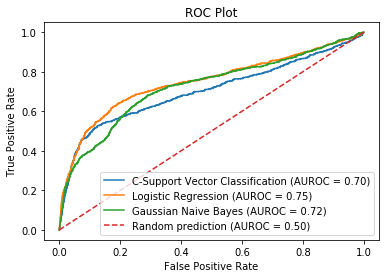

In [30]:
# setting the plot

plt.plot(scv_fpr, scv_tpr, marker='.', label='C-Support Vector Classification (AUROC = %0.2f)' % scv_auc, markersize = 0.1)
plt.plot(logreg_fpr, logreg_tpr, marker='.', label='Logistic Regression (AUROC = %0.2f)' % logreg_auc, markersize = 0.1)
plt.plot(gausreg_fpr, gausreg_tpr, marker='.', label='Gaussian Naive Bayes (AUROC = %0.2f)' % gausreg_auc, markersize = 0.1)

plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.2f)' % r_auc)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

* recived the ROC curve as well as the scores of accuracy and AUC indicate that the tuned Logistic Regression model is the best one.

### PREDICTING ON CAMPAIGN SUBSET

In [31]:
# fitting the model
logreg = LogisticRegression(C = C_logreg, max_iter = 1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [32]:
#preprocessing campaign data
X_camp = df_camp.drop(["contact", "month", "default", "day_of_week", "duration", "campaign", "y", "test_control_flag"], axis = "columns")
y_camp = df_camp[["y"]]

column_trans = make_column_transformer(
    (OneHotEncoder(), ['job', 'marital', 'education', 'housing', 'loan', 'poutcome']),
    remainder='passthrough')

X_camp_transformed = column_trans.fit_transform(X_camp)
y_camp_transformed = np.ravel(y_camp)

l = []
for i in y_camp_transformed:
    if i == "yes":
        l.append(1)
    else:
        l.append(0)

y_camp_transformed = l

In [33]:
#scores on control data set
print(confusion_matrix(y_test, y_pred, labels = [1, 0]))
print("Precision on control data: {}".format(precision_score(y_test, y_pred, labels = [1, 0])))

[[ 112  614]
 [  55 6596]]
Precision on control data: 0.6706586826347305


In [34]:
#predicting labels on campaign data set
y_camp_pred = logreg.predict(X_camp_transformed)

In [35]:
#scores on campaign data set
print((confusion_matrix(y_camp_transformed, y_camp_pred, labels = [1, 0])))
print("Precision on campaign data: {}".format(precision_score(y_camp_transformed, y_camp_pred, labels = [1, 0])))

[[  283  1572]
 [  105 14505]]
Precision on campaign data: 0.729381443298969


* marketing campaign encourage people to accept the offered product, thus it "softens" the borders simulated within the model - that is why precision on campaign subset is higher (superb outcome)

### THE LIFT
To assess the lift of the model I assumed that "the total campaign budget is fixed" means that marketers have only capacity to call to fixed number of people or have fix time for those phone calls.

Let's say that marketers have "call-to list". Probability that person buys a product is calculated by dividing actual number of people that bought the product by total number of people on the list. For model this metric is equivalent to its precision.

In [36]:
#calc. the lift of the model

precision_of_random_choice = len(df_camp[df_camp.y == "yes"].values)/len(df_camp.values)
print("precision_of_random_choice: %0.3f" %precision_of_random_choice)

precision_of_the_model = precision_score(y_camp_transformed, y_camp_pred, labels = [1, 0])
print("precision_of_the_model: %0.3f" % precision_of_the_model)

lift = (precision_of_the_model - precision_of_random_choice) / precision_of_random_choice
print("lift: {:.2%}".format(lift))

precision_of_random_choice: 0.113
precision_of_the_model: 0.729
lift: 547.40%


* assuming that the profit from subscrition to the term deposit is also fixed for every transation, we might expect that the total profit will  increase 5 times.